# Product network

## Create fake data

In [47]:
import numpy as np
import pandas as pd

def generate_weighted_adjacency_matrix_geometric(n, p=0.5):
    """
    Generate a fake directed weighted adjacency matrix for product features with geometrically distributed weights,
    including 'entrance' and 'exit' nodes.
    
    Parameters:
    - n: int, the number of product features (feature_1 to feature_n).
    - p: float, the probability of success in the geometric distribution.
    
    Returns:
    - adjacency_matrix: pd.DataFrame, the generated adjacency matrix.
    """
    # Total number of nodes including 'entrance' and 'exit'
    total_nodes = n + 2
    
    # Initialize the adjacency matrix with zeros
    adjacency_matrix = np.zeros((total_nodes, total_nodes))
    
    # Populate the matrix with geometrically distributed weights
    for i in range(total_nodes):
        for j in range(total_nodes):
            if i != j:
                # Randomly decide if there should be an edge
                if np.random.rand() > 0.5:
                    # Assign a weight drawn from a geometric distribution
                    adjacency_matrix[i][j] = np.random.geometric(p)
    
    # Ensure no flow into 'entrance' (first row should be zero except for outgoing edges)
    adjacency_matrix[:, 0] = 0
    
    # Ensure no flow out of 'exit' (last column should be zero except for incoming edges)
    adjacency_matrix[-1, :] = 0
    
    # Create feature names including 'entrance' and 'exit'
    feature_names = ['entrance'] + [f'feature_{i+1}' for i in range(n)] + ['exit']
    
    # Convert to DataFrame for better readability
    adjacency_df = pd.DataFrame(adjacency_matrix, index=feature_names, columns=feature_names)
    
    return adjacency_df

def generate_multiple_matrices(n, p, dims):
    """
    Generate multiple weighted adjacency matrices for different values of the dim variable.
    
    Parameters:
    - n: int, the number of product features (feature_1 to feature_n).
    - p: float, the probability of success in the geometric distribution.
    - dims: list, the different values of the dim variable.
    
    Returns:
    - long_format_df: pd.DataFrame, the long format DataFrame with an additional dim variable.
    """
    all_matrices = []
    
    for dim in dims:
        adj_matrix = generate_weighted_adjacency_matrix_geometric(n, p)
        adj_matrix['dim'] = dim
        adj_matrix = adj_matrix.reset_index().melt(id_vars=['index', 'dim'], var_name='to', value_name='weight')
        adj_matrix.rename(columns={'index': 'from'}, inplace=True)
        all_matrices.append(adj_matrix)
    
    # Concatenate all matrices
    long_format_df = pd.concat(all_matrices, ignore_index=True)
    
    # Reorder columns to ensure 'dim' is the first column
    cols = ['dim', 'from', 'to', 'weight']
    long_format_df = long_format_df[cols]
    
    return long_format_df

# Example usage:
n = 5  # Number of product features
p = 0.05
dims = ['A', 'B', 'C']  # Different values for the dim variable
data = generate_multiple_matrices(n, p, dims)
data

,dim,from,to,weight
0,A,entrance,entrance,0.0
1,A,feature_1,entrance,0.0
2,A,feature_2,entrance,0.0
3,A,feature_3,entrance,0.0
4,A,feature_4,entrance,0.0
...,...,...,...,...
142,C,feature_2,exit,0.0
143,C,feature_3,exit,0.0
144,C,feature_4,exit,12.0
145,C,feature_5,exit,0.0


## Create graph

In [50]:
import networkx as nx
import numpy as np
import pandas as pd

def create_graph(adjacency_df):
    """
    Create a directed weighted graph from the adjacency matrix using NetworkX.
    
    Parameters:
    - adjacency_df: pd.DataFrame, the adjacency matrix to convert into a graph.
    
    Returns:
    - G: networkx.DiGraph, the generated directed weighted graph.
    """
    G = nx.DiGraph()
    
    # Add edges with weights
    for index, row in adjacency_df.iterrows():
        from_node = row['from']
        to_node = row['to']
        weight = row['weight']
        if weight > 0:
            G.add_edge(from_node, to_node, weight=weight)
    
    return G

def create_graphs_by_dim(long_format_df):
    """
    Create separate graphs for each dimension from the long format DataFrame.
    
    Parameters:
    - long_format_df: pd.DataFrame, the long format DataFrame with 'dim', 'from', 'to', and 'weight' columns.
    
    Returns:
    - graphs: dict, a dictionary with dimension names as keys and NetworkX graphs as values.
    """
    graphs = {}
    
    for dim in long_format_df['dim'].unique():
        dim_df = long_format_df[long_format_df['dim'] == dim]
        graphs[dim] = create_graph(dim_df)
    
    return graphs

# Example usage:
n = 5  # Number of product features
p = 0.05
dims = ['A', 'B', 'C']  # Different values for the dim variable

# Generate the long format DataFrame
long_format_df = generate_multiple_matrices(n, p, dims)

# Create separate graphs for each dimension
graphs = create_graphs_by_dim(long_format_df)

# Print the graphs to verify
for dim, graph in graphs.items():
    print(f"Graph for dimension {dim}:")
    print(graph.edges(data=True))

Graph for dimension A:
[('entrance', 'feature_1', {'weight': 37.0}), ('entrance', 'feature_3', {'weight': 11.0}), ('entrance', 'feature_4', {'weight': 21.0}), ('entrance', 'exit', {'weight': 13.0}), ('feature_1', 'feature_2', {'weight': 48.0}), ('feature_1', 'feature_3', {'weight': 9.0}), ('feature_1', 'feature_4', {'weight': 25.0}), ('feature_1', 'feature_5', {'weight': 43.0}), ('feature_2', 'feature_1', {'weight': 10.0}), ('feature_2', 'feature_3', {'weight': 9.0}), ('feature_2', 'feature_4', {'weight': 5.0}), ('feature_4', 'feature_1', {'weight': 94.0}), ('feature_4', 'feature_5', {'weight': 23.0}), ('feature_4', 'exit', {'weight': 70.0}), ('feature_5', 'feature_1', {'weight': 5.0}), ('feature_5', 'feature_2', {'weight': 15.0}), ('feature_5', 'feature_3', {'weight': 6.0}), ('feature_3', 'feature_4', {'weight': 5.0})]
Graph for dimension B:
[('feature_2', 'feature_1', {'weight': 13.0}), ('feature_2', 'feature_4', {'weight': 12.0}), ('feature_2', 'feature_5', {'weight': 7.0}), ('featu

## Visualise graph



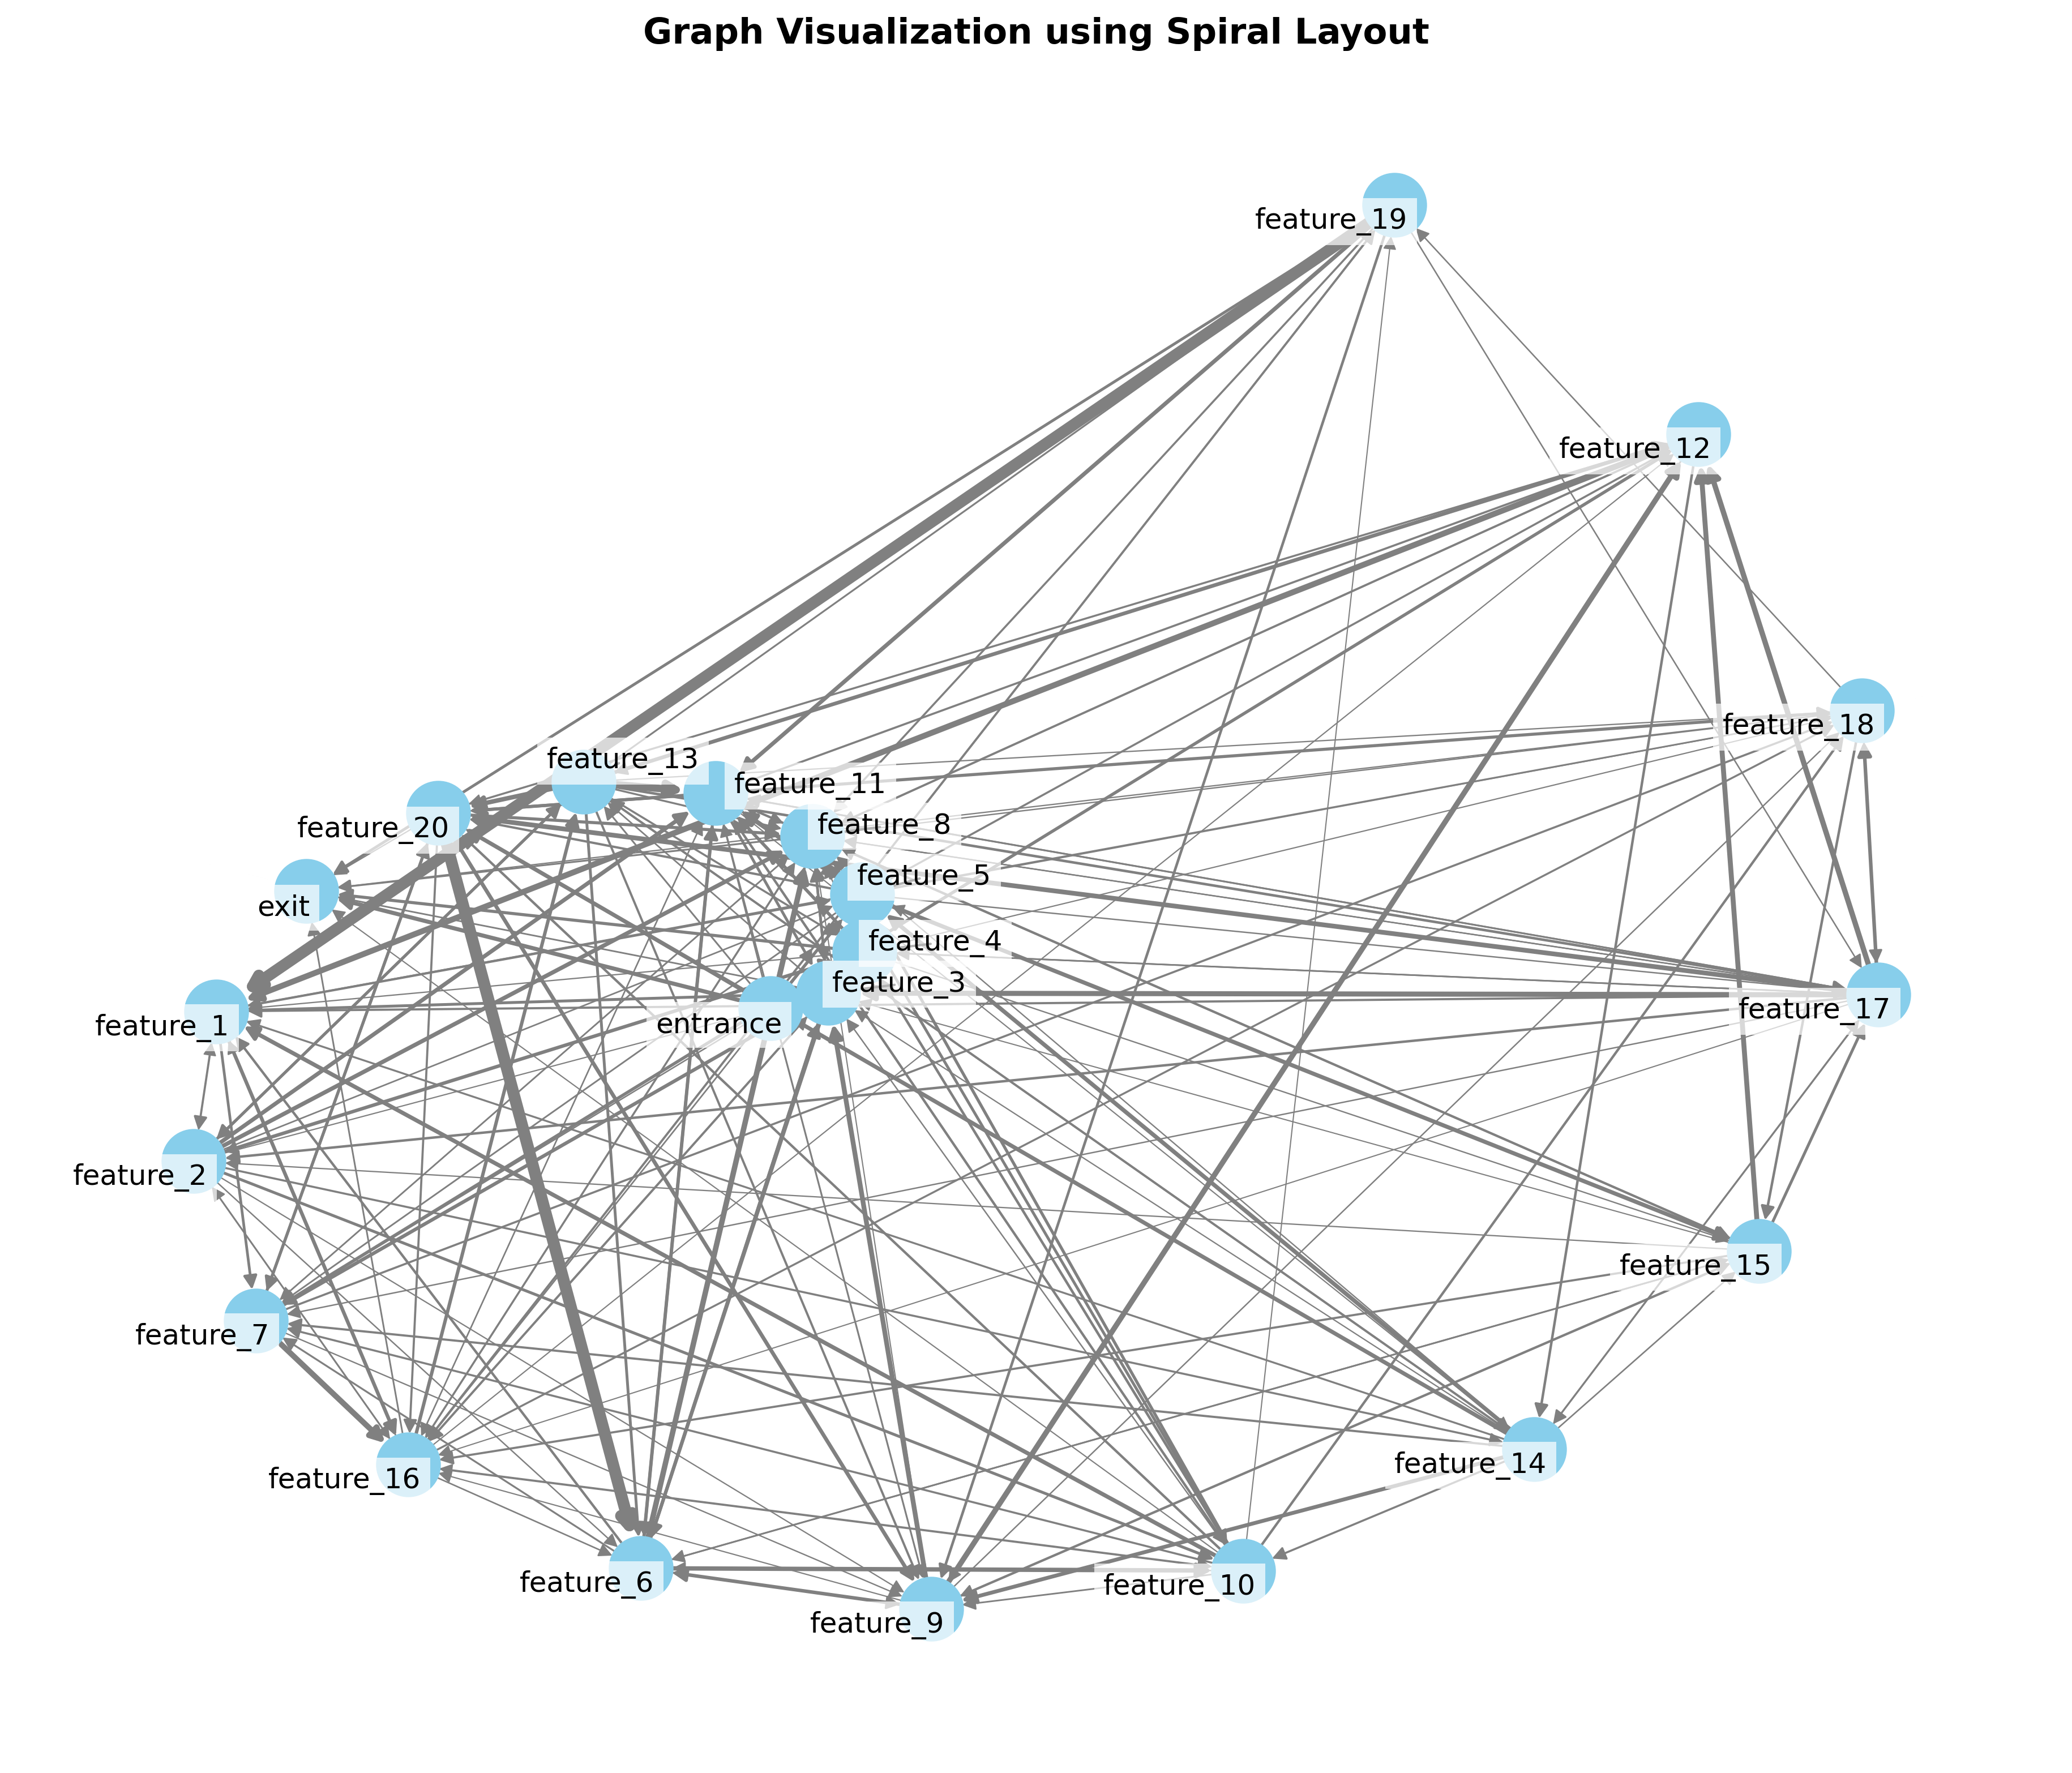

In [45]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

def normalize_weights(weights, min_thickness=0.5, max_thickness=5.0):
    """
    Normalize weights to a specified range for visualization.
    
    Parameters:
    - weights: list, the weights to normalize.
    - min_thickness: float, the minimum thickness value.
    - max_thickness: float, the maximum thickness value.
    
    Returns:
    - list, the normalized weights.
    """
    min_weight = min(weights)
    max_weight = max(weights)
    normalized_weights = [(max_thickness - min_thickness) * (weight - min_weight) / (max_weight - min_weight) + min_thickness for weight in weights]
    return normalized_weights

def visualise_graph(G, layout='spring'):
    """
    Visualize the directed weighted graph using the specified NetworkX layout.
    
    Parameters:
    - G: networkx.DiGraph, the graph to visualize.
    - layout: str, the layout to use for visualization. Options include 'spring', 'circular', 'kamada_kawai', 'shell', 'spectral', 'spiral', 'planar', 'random', 'multipartite', 'bipartite'.
    """
    # Determine the layout
    if layout == 'spring':
        pos = nx.spring_layout(G)
    elif layout == 'circular':
        pos = nx.circular_layout(G)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G)
    elif layout == 'shell':
        pos = nx.shell_layout(G)
    elif layout == 'spectral':
        pos = nx.spectral_layout(G)
    elif layout == 'spiral':
        pos = nx.spiral_layout(G)
    elif layout == 'planar':
        pos = nx.planar_layout(G)
    elif layout == 'random':
        pos = nx.random_layout(G)
    elif layout == 'multipartite':
        pos = nx.multipartite_layout(G, subset_key='subset')
    elif layout == 'bipartite':
        # Assumes nodes have a 'bipartite' attribute, where 0 or 1 indicates the part
        top_nodes = [n for n, d in G.nodes(data=True) if d.get('bipartite') == 0]
        pos = nx.bipartite_layout(G, nodes=top_nodes)
    else:
        raise ValueError(f"Unknown layout: {layout}")
    
    # Extract and normalize edge weights
    edge_weights = [d['weight'] for u, v, d in G.edges(data=True)]
    normalized_weights = normalize_weights(edge_weights)
    edge_weight_dict = {(u, v): normalized_weights[i] for i, (u, v) in enumerate(G.edges())}

    # Set up the plot
    plt.figure(figsize=(12, 10), dpi=300)
    
    # Draw nodes and edges
    nx.draw(
        G, pos, with_labels=False, node_size=700, node_color='skyblue', font_size=12, font_weight='bold',
        edge_color='grey', width=list(edge_weight_dict.values()), arrows=True, arrowstyle='-|>', arrowsize=12
    )

    # Draw labels with adjust_text to avoid overlap
    texts = []
    for node, (x, y) in pos.items():
        texts.append(plt.text(x, y, node, fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)))
    
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))

    # Enhance aesthetics
    plt.title(f'Graph Visualization using {layout.capitalize()} Layout', fontsize=15, fontweight='bold')
    plt.axis('off')

    # Save the figure for publication
    plt.savefig(f'graph_{layout}.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage (you need to define or load your graph G)
# G = nx.DiGraph()
# Add nodes and edges to G
# visualise_graph(G, layout='spring')
# visualise_graph(G, layout='circular')
# visualise_graph(G, layout='kamada_kawai')
# visualise_graph(G, layout='shell')
# visualise_graph(G, layout='spectral')
visualise_graph(G, layout='spiral')
# visualise_graph(G, layout='bipartite')
# visualise_graph(G, layout='multipartite')

# Metrics